In [1]:
import numpy as np
from model_aug_shiftx import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [ ]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [ ]:
checkpoint_dir = "./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint"
sample_dir = "./out/shiftx_5px_aug_inplace_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [ ]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

loading mnist...
 [*] Reading checkpoints... ./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/shiftx_5px_aug_inplace_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


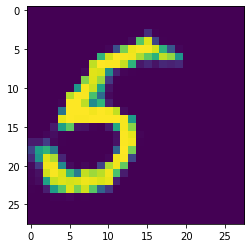

In [ ]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [ ]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder+alpha*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [ ]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    if alpha == 0:
        return outputs_zs, mask_fn
    
    M = np.float32([[1,0,alpha],[0,1,0]])
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size)), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size)), axis=2)

    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
        
    if show_img:
        print('Target image:')
#         imshow_unscaled(target_fn)
        imshow(target_fn[0,:,:,0], im_size=128)
    if show_mask:
        print('Target mask:')
#         imshow_unscaled(mask_out)
        imshow(mask_out[0,:,:,0], im_size=128)

    return target_fn, mask_out

In [ ]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/walk_train_aug/shiftx_l2_git{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [ ]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            alpha_val = np.random.randint(1, 6)  
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = -alpha_val

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)
#             Loss_sum = Loss_sum + curr_loss
#             loss_values.append(curr_loss)

#             elapsed_time = time.time() - start_time

#             logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))
                
#             alpha_list.append(alpha_val)

#             if (optim_iter % 100 == 0) and (optim_iter > 0):
#                 saver.save(sess, './shift_l2_git/model_{}.ckpt'.format(optim_iter*batch_size), write_meta_graph=False, write_state=False)

#             optim_iter = optim_iter+1
            
#     if optim_iter > 0:
#         print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
#     saver.save(sess, "./shift_l2_git/model_{}_final.ckpt".format(optim_iter*batch_size), write_meta_graph=False, write_state=False)
#     return loss_values
            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [ ]:
train(dcgan.saver)

2019-09-10 14:05:41,875 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.3037283420562744, 0, 0, 0.2322734147310257, 3
2019-09-10 14:05:41,884 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007953643798828125, 0, 10, 0.17283408343791962, -4
2019-09-10 14:05:41,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008328676223754883, 0, 20, 0.11371823400259018, 1
2019-09-10 14:05:41,902 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007783174514770508, 0, 30, 0.15256895124912262, -3
2019-09-10 14:05:41,911 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007668256759643555, 0, 40, 0.2829360067844391, 5
2019-09-10 14:05:41,919 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006853818893432617, 0, 50, 0.1023043617606163, -2
2019-09-10 14:05:41,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006744384765625, 0, 60, 0.1226835623383522, -3
2019-09-10 14:05:41,934 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006020545959472656, 0, 70, 0.15575048327445984, -5
2019-09-10 14:05:41,941 [MainThread  

2019-09-10 14:05:42,373 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006620883941650391, 0, 680, 0.15861938893795013, 3
2019-09-10 14:05:42,381 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006804227828979492, 0, 690, 0.13284823298454285, -5
2019-09-10 14:05:42,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006751537322998047, 0, 700, 0.05647167190909386, 1
2019-09-10 14:05:42,398 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007814884185791016, 0, 710, 0.06204850971698761, -1
2019-09-10 14:05:42,406 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00768589973449707, 0, 720, 0.11375215649604797, 2
2019-09-10 14:05:42,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0075130462646484375, 0, 730, 0.21365301311016083, 4
2019-09-10 14:05:42,422 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067996978759765625, 0, 740, 0.05818995088338852, 1
2019-09-10 14:05:42,429 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006144046783447266, 0, 750, 0.13553515076637268, -4
2019-09-10 14:05:42,

2019-09-10 14:05:42,934 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005906105041503906, 0, 1350, 0.03368588164448738, -1
2019-09-10 14:05:42,941 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006356477737426758, 0, 1360, 0.17473913729190826, 5
2019-09-10 14:05:42,948 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063512325286865234, 0, 1370, 0.14948225021362305, -5
2019-09-10 14:05:42,957 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008304595947265625, 0, 1380, 0.1147909089922905, 3
2019-09-10 14:05:42,967 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008257389068603516, 0, 1390, 0.15776541829109192, 4
2019-09-10 14:05:42,976 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008091926574707031, 0, 1400, 0.06889667361974716, 2
2019-09-10 14:05:42,986 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008417367935180664, 0, 1410, 0.10116224735975266, -2
2019-09-10 14:05:42,995 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007469892501831055, 0, 1420, 0.16934001445770264, 5
2019-09-10 14

2019-09-10 14:05:43,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006374835968017578, 0, 2020, 0.052767615765333176, 2
2019-09-10 14:05:43,469 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0073893070220947266, 0, 2030, 0.09974034875631332, -3
2019-09-10 14:05:43,477 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006901264190673828, 0, 2040, 0.15292443335056305, -5
2019-09-10 14:05:43,483 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006153583526611328, 0, 2050, 0.09484104812145233, -3
2019-09-10 14:05:43,493 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009462833404541016, 0, 2060, 0.14056210219860077, 5
2019-09-10 14:05:43,505 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010775327682495117, 0, 2070, 0.1360415369272232, -5
2019-09-10 14:05:43,512 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065441131591796875, 0, 2080, 0.16498661041259766, 5
2019-09-10 14:05:43,519 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006197690963745117, 0, 2090, 0.1682589203119278, 5
2019-09-10 

2019-09-10 14:05:43,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008263587951660156, 0, 2690, 0.0180946234613657, 1
2019-09-10 14:05:43,969 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008333921432495117, 0, 2700, 0.11336583644151688, -4
2019-09-10 14:05:43,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00787043571472168, 0, 2710, 0.02438783273100853, 1
2019-09-10 14:05:43,986 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007779836654663086, 0, 2720, 0.1462978720664978, -5
2019-09-10 14:05:43,996 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008781909942626953, 0, 2730, 0.10096368938684464, -3
2019-09-10 14:05:44,005 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008147478103637695, 0, 2740, 0.10516730695962906, -5
2019-09-10 14:05:44,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007871866226196289, 0, 2750, 0.08750775456428528, 3
2019-09-10 14:05:44,023 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007994413375854492, 0, 2760, 0.1273995041847229, 5
2019-09-10 14:05

2019-09-10 14:05:44,477 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00792694091796875, 0, 3350, 0.02432188391685486, -1
2019-09-10 14:05:44,485 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007459163665771484, 0, 3360, 0.1403263509273529, -5
2019-09-10 14:05:44,493 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0070917606353759766, 0, 3370, 0.045175883919000626, 2
2019-09-10 14:05:44,501 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007343292236328125, 0, 3380, 0.08292477577924728, 3
2019-09-10 14:05:44,509 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006944894790649414, 0, 3390, 0.12855876982212067, 5
2019-09-10 14:05:44,515 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005751132965087891, 0, 3400, 0.02290862239897251, 1
2019-09-10 14:05:44,522 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006669759750366211, 0, 3410, 0.09431950747966766, 3
2019-09-10 14:05:44,530 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0074231624603271484, 0, 3420, 0.09806731343269348, -3
2019-09-10 1

2019-09-10 14:05:45,033 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008496999740600586, 0, 4010, 0.06351549923419952, 3
2019-09-10 14:05:45,042 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007911920547485352, 0, 4020, 0.06297878175973892, -2
2019-09-10 14:05:45,051 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008580446243286133, 0, 4030, 0.10926419496536255, -4
2019-09-10 14:05:45,059 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00748443603515625, 0, 4040, 0.02553337812423706, 1
2019-09-10 14:05:45,071 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011197805404663086, 0, 4050, 0.12782849371433258, -5
2019-09-10 14:05:45,079 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006796598434448242, 0, 4060, 0.027913197875022888, -1
2019-09-10 14:05:45,086 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065135955810546875, 0, 4070, 0.13053244352340698, 5
2019-09-10 14:05:45,093 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005823850631713867, 0, 4080, 0.04256153851747513, 2
2019-09-10 

2019-09-10 14:05:45,544 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064525604248046875, 0, 4680, 0.07694651931524277, 4
2019-09-10 14:05:45,554 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008913755416870117, 0, 4690, 0.10517112910747528, -4
2019-09-10 14:05:45,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007883310317993164, 0, 4700, 0.08166077733039856, -3
2019-09-10 14:05:45,569 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005850553512573242, 0, 4710, 0.10717873275279999, 5
2019-09-10 14:05:45,577 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007289409637451172, 0, 4720, 0.08282877504825592, -4
2019-09-10 14:05:45,584 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006473541259765625, 0, 4730, 0.02666240744292736, 1
2019-09-10 14:05:45,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058743953704833984, 0, 4740, 0.042840417474508286, 2
2019-09-10 14:05:45,598 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006738185882568359, 0, 4750, 0.054880980402231216, 3
2019-09-1

2019-09-10 14:05:46,042 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0070836544036865234, 0, 5340, 0.017231451347470284, -1
2019-09-10 14:05:46,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007638216018676758, 0, 5350, 0.05326532572507858, 2
2019-09-10 14:05:46,058 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007344722747802734, 0, 5360, 0.09191406518220901, 4
2019-09-10 14:05:46,067 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007588624954223633, 0, 5370, 0.11740875989198685, 5
2019-09-10 14:05:46,075 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00724482536315918, 0, 5380, 0.05875248461961746, 3
2019-09-10 14:05:46,083 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007560253143310547, 0, 5390, 0.021391045302152634, -1
2019-09-10 14:05:46,091 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006905317306518555, 0, 5400, 0.04589252546429634, 2
2019-09-10 14:05:46,098 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006161689758300781, 0, 5410, 0.04719989374279976, -2
2019-09-10 

Loss: [0.013845058403909207, 0.010109843635931611, 0.008296586325392126, 0.008041029470041395, 0.007034999149851501, 0.006505179588682949]
2019-09-10 14:05:46,578 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00805354118347168, 0, 6010, 0.07619672268629074, -3
2019-09-10 14:05:46,589 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009879827499389648, 0, 6020, 0.07826116681098938, 4
2019-09-10 14:05:46,597 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007399320602416992, 0, 6030, 0.019822224974632263, -1
2019-09-10 14:05:46,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00857853889465332, 0, 6040, 0.06909281015396118, 3
2019-09-10 14:05:46,614 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067195892333984375, 0, 6050, 0.042121220380067825, -2
2019-09-10 14:05:46,623 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008000373840332031, 0, 6060, 0.06983882933855057, 3
2019-09-10 14:05:46,632 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007936954498291016, 0, 6070, 0.05460910126566887

2019-09-10 14:05:47,149 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007104396820068359, 0, 6670, 0.04823005199432373, 2
2019-09-10 14:05:47,156 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00710296630859375, 0, 6680, 0.07732066512107849, 4
2019-09-10 14:05:47,165 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007522106170654297, 0, 6690, 0.08358205109834671, -4
2019-09-10 14:05:47,175 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008580207824707031, 0, 6700, 0.1162998378276825, 4
2019-09-10 14:05:47,187 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010863065719604492, 0, 6710, 0.05453060567378998, -3
2019-09-10 14:05:47,198 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009282827377319336, 0, 6720, 0.08273638784885406, -4
2019-09-10 14:05:47,208 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008877277374267578, 0, 6730, 0.10564889758825302, 5
2019-09-10 14:05:47,220 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010564088821411133, 0, 6740, 0.07574499398469925, -3
2019-09-10 14:

2019-09-10 14:05:47,772 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007831573486328125, 0, 7330, 0.05633292347192764, 3
2019-09-10 14:05:47,780 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0076029300689697266, 0, 7340, 0.02115931548178196, -1
2019-09-10 14:05:47,789 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007614850997924805, 0, 7350, 0.08818051218986511, 5
2019-09-10 14:05:47,797 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007746458053588867, 0, 7360, 0.035679686814546585, -2
2019-09-10 14:05:47,806 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007960796356201172, 0, 7370, 0.08614569157361984, -4
2019-09-10 14:05:47,815 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008317947387695312, 0, 7380, 0.08624804764986038, -5
2019-09-10 14:05:47,824 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00814366340637207, 0, 7390, 0.017092114314436913, -1
2019-09-10 14:05:47,835 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009380578994750977, 0, 7400, 0.09865540266036987, -4
2019-09-

2019-09-10 14:05:48,374 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006335735321044922, 0, 8000, 0.018472794443368912, 1
Loss: [0.013845058403909207, 0.010109843635931611, 0.008296586325392126, 0.008041029470041395, 0.007034999149851501, 0.006505179588682949, 0.00620137388445437, 0.006328733203932643]
2019-09-10 14:05:48,381 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005821943283081055, 0, 8010, 0.03227247670292854, -2
2019-09-10 14:05:48,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005426645278930664, 0, 8020, 0.10981178283691406, -5
2019-09-10 14:05:48,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00611424446105957, 0, 8030, 0.09040886908769608, -4
2019-09-10 14:05:48,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010004758834838867, 0, 8040, 0.09243413805961609, 4
2019-09-10 14:05:48,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008715152740478516, 0, 8050, 0.08181128650903702, 4
2019-09-10 14:05:48,423 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008309

2019-09-10 14:05:48,881 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008264303207397461, 0, 8650, 0.05625833570957184, 3
2019-09-10 14:05:48,889 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006796836853027344, 0, 8660, 0.11555417627096176, 5
2019-09-10 14:05:48,896 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006785154342651367, 0, 8670, 0.020751800388097763, 1
2019-09-10 14:05:48,906 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00906825065612793, 0, 8680, 0.09761194884777069, 5
2019-09-10 14:05:48,917 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01020359992980957, 0, 8690, 0.04726754128932953, -2
2019-09-10 14:05:48,925 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007390737533569336, 0, 8700, 0.052897460758686066, -3
2019-09-10 14:05:48,935 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00864410400390625, 0, 8710, 0.021200992166996002, 1
2019-09-10 14:05:48,945 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009322643280029297, 0, 8720, 0.01756402850151062, 1
2019-09-10 14:

2019-09-10 14:05:49,373 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006096363067626953, 0, 9300, 0.06818024069070816, -3
2019-09-10 14:05:49,380 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006169319152832031, 0, 9310, 0.0230848528444767, -1
2019-09-10 14:05:49,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006039857864379883, 0, 9320, 0.06082319840788841, -3
2019-09-10 14:05:49,393 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005704164505004883, 0, 9330, 0.04771004989743233, -2
2019-09-10 14:05:49,400 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006031036376953125, 0, 9340, 0.09569309651851654, -5
2019-09-10 14:05:49,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006361722946166992, 0, 9350, 0.11530646681785583, 4
2019-09-10 14:05:49,414 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00625157356262207, 0, 9360, 0.05611531063914299, -2
2019-09-10 14:05:49,421 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006475925445556641, 0, 9370, 0.01988373138010502, 1
2019-09-10 1

2019-09-10 14:05:49,839 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007611751556396484, 0, 9970, 0.05862985551357269, -3
2019-09-10 14:05:49,846 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005606889724731445, 0, 9980, 0.12017808854579926, 5
2019-09-10 14:05:49,852 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005804777145385742, 0, 9990, 0.06692244857549667, 3
2019-09-10 14:05:49,858 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005769491195678711, 0, 10000, 0.05686045065522194, 3
Loss: [0.013845058403909207, 0.010109843635931611, 0.008296586325392126, 0.008041029470041395, 0.007034999149851501, 0.006505179588682949, 0.00620137388445437, 0.006328733203932643, 0.006123428649269044, 0.006013248421251774]
2019-09-10 14:05:49,864 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005581855773925781, 0, 10010, 0.04240582138299942, -2
2019-09-10 14:05:49,870 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005397796630859375, 0, 10020, 0.04126034304499626, -2
2019-09-10 14:05:49,877 [MainT

2019-09-10 14:05:50,364 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006562948226928711, 0, 10610, 0.11124545335769653, -5
2019-09-10 14:05:50,372 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0071561336517333984, 0, 10620, 0.07366441935300827, -3
2019-09-10 14:05:50,380 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007485389709472656, 0, 10630, 0.047581177204847336, 2
2019-09-10 14:05:50,389 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008001327514648438, 0, 10640, 0.0810951441526413, 4
2019-09-10 14:05:50,397 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007329702377319336, 0, 10650, 0.0465594120323658, 2
2019-09-10 14:05:50,407 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009063720703125, 0, 10660, 0.07979067414999008, 5
2019-09-10 14:05:50,416 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007914304733276367, 0, 10670, 0.020762618631124496, 1
2019-09-10 14:05:50,423 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006386518478393555, 0, 10680, 0.11553151160478592, 5
2019-09-

2019-09-10 14:05:50,899 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010661602020263672, 0, 11250, 0.054731886833906174, 3
2019-09-10 14:05:50,907 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007059335708618164, 0, 11260, 0.07555502653121948, 3
2019-09-10 14:05:50,916 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0075681209564208984, 0, 11270, 0.06010667234659195, 4
2019-09-10 14:05:50,924 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007646083831787109, 0, 11280, 0.07579085230827332, 4
2019-09-10 14:05:50,931 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00643467903137207, 0, 11290, 0.019781332463026047, -1
2019-09-10 14:05:50,941 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00934147834777832, 0, 11300, 0.01860835961997509, 1
2019-09-10 14:05:50,951 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008780956268310547, 0, 11310, 0.08131586760282516, -3
2019-09-10 14:05:50,957 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005761623382568359, 0, 11320, 0.05231666564941406, -2
2019

2019-09-10 14:05:51,405 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005655765533447266, 0, 11910, 0.09694309532642365, 5
2019-09-10 14:05:51,411 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005467414855957031, 0, 11920, 0.08175373822450638, -4
2019-09-10 14:05:51,417 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005304098129272461, 0, 11930, 0.038466181606054306, 2
2019-09-10 14:05:51,423 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057582855224609375, 0, 11940, 0.014264469034969807, 1
2019-09-10 14:05:51,431 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064165592193603516, 0, 11950, 0.10667859017848969, -5
2019-09-10 14:05:51,438 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068721771240234375, 0, 11960, 0.018261997029185295, -1
2019-09-10 14:05:51,445 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005770683288574219, 0, 11970, 0.10318814218044281, -5
2019-09-10 14:05:51,452 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068318843841552734, 0, 11980, 0.06360895931720734,

2019-09-10 14:05:51,899 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006780147552490234, 0, 12550, 0.04056166484951973, -2
2019-09-10 14:05:51,906 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065555572509765625, 0, 12560, 0.05881720781326294, 3
2019-09-10 14:05:51,913 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006613969802856445, 0, 12570, 0.016087884083390236, 1
2019-09-10 14:05:51,920 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006354570388793945, 0, 12580, 0.0495070181787014, -2
2019-09-10 14:05:51,927 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005971670150756836, 0, 12590, 0.09551558643579483, 5
2019-09-10 14:05:51,933 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005378246307373047, 0, 12600, 0.0756579264998436, -4
2019-09-10 14:05:51,942 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008695125579833984, 0, 12610, 0.038762710988521576, 2
2019-09-10 14:05:51,949 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006008148193359375, 0, 12620, 0.024196015670895576, -1
20

2019-09-10 14:05:52,379 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006471157073974609, 0, 13190, 0.015984758734703064, -1
2019-09-10 14:05:52,387 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007277488708496094, 0, 13200, 0.07712513208389282, 4
2019-09-10 14:05:52,394 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0061872005462646484, 0, 13210, 0.04210670292377472, -2
2019-09-10 14:05:52,401 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006421566009521484, 0, 13220, 0.040355414152145386, 2
2019-09-10 14:05:52,408 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064008235931396484, 0, 13230, 0.11136925965547562, 5
2019-09-10 14:05:52,415 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006075143814086914, 0, 13240, 0.0754949152469635, -3
2019-09-10 14:05:52,430 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01417398452758789, 0, 13250, 0.05258496105670929, -3
2019-09-10 14:05:52,438 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007282257080078125, 0, 13260, 0.1095462366938591, -5
20

2019-09-10 14:05:52,929 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009163141250610352, 0, 13850, 0.06537588685750961, -3
2019-09-10 14:05:52,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006626605987548828, 0, 13860, 0.10922986268997192, -5
2019-09-10 14:05:52,945 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007853031158447266, 0, 13870, 0.0930643230676651, 5
2019-09-10 14:05:52,952 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005637407302856445, 0, 13880, 0.06347227096557617, 3
2019-09-10 14:05:52,959 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006791114807128906, 0, 13890, 0.03581313416361809, -2
2019-09-10 14:05:52,966 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005824565887451172, 0, 13900, 0.09675996005535126, -5
2019-09-10 14:05:52,973 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006262302398681641, 0, 13910, 0.03376303240656853, -2
2019-09-10 14:05:52,980 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006182670593261719, 0, 13920, 0.02617138996720314, 2
2019

2019-09-10 14:05:53,440 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008204460144042969, 0, 14490, 0.09790945053100586, -5
2019-09-10 14:05:53,449 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007451772689819336, 0, 14500, 0.07736527174711227, 5
2019-09-10 14:05:53,457 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00717926025390625, 0, 14510, 0.07193421572446823, 3
2019-09-10 14:05:53,465 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007350921630859375, 0, 14520, 0.09424072504043579, 5
2019-09-10 14:05:53,472 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006611347198486328, 0, 14530, 0.09123500436544418, -5
2019-09-10 14:05:53,479 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006029844284057617, 0, 14540, 0.04407413303852081, 2
2019-09-10 14:05:53,488 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007967233657836914, 0, 14550, 0.014797911047935486, -1
2019-09-10 14:05:53,497 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007802486419677734, 0, 14560, 0.01811150461435318, -1
2019

2019-09-10 14:05:53,973 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005956411361694336, 0, 15130, 0.045871615409851074, 3
2019-09-10 14:05:53,980 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006235599517822266, 0, 15140, 0.015902800485491753, 1
2019-09-10 14:05:53,986 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006112813949584961, 0, 15150, 0.037956882268190384, -2
2019-09-10 14:05:53,994 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006590843200683594, 0, 15160, 0.08105306327342987, 5
2019-09-10 14:05:54,001 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006545543670654297, 0, 15170, 0.03889438137412071, 2
2019-09-10 14:05:54,009 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0073549747467041016, 0, 15180, 0.08711743354797363, -4
2019-09-10 14:05:54,018 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00744175910949707, 0, 15190, 0.10038209706544876, -5
2019-09-10 14:05:54,026 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007885217666625977, 0, 15200, 0.09521736204624176, 5
20

2019-09-10 14:05:54,478 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006695985794067383, 0, 15790, 0.03771122545003891, -3
2019-09-10 14:05:54,486 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006246089935302734, 0, 15800, 0.0342119000852108, -2
2019-09-10 14:05:54,496 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009247064590454102, 0, 15810, 0.10872027277946472, -5
2019-09-10 14:05:54,503 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065059661865234375, 0, 15820, 0.09206851571798325, 5
2019-09-10 14:05:54,510 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006509542465209961, 0, 15830, 0.0532972514629364, -3
2019-09-10 14:05:54,518 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006282806396484375, 0, 15840, 0.08985722064971924, 5
2019-09-10 14:05:54,525 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006532907485961914, 0, 15850, 0.016606256365776062, 1
2019-09-10 14:05:54,533 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006509304046630859, 0, 15860, 0.07926397770643234, -4
201

2019-09-10 14:05:55,010 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065228939056396484, 0, 16420, 0.10159085690975189, -5
2019-09-10 14:05:55,018 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007813215255737305, 0, 16430, 0.022869111970067024, -1
2019-09-10 14:05:55,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007576465606689453, 0, 16440, 0.016569912433624268, 1
2019-09-10 14:05:55,035 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006883859634399414, 0, 16450, 0.0931236669421196, 5
2019-09-10 14:05:55,043 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007663726806640625, 0, 16460, 0.02171577699482441, -1
2019-09-10 14:05:55,051 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007370710372924805, 0, 16470, 0.06704692542552948, 3
2019-09-10 14:05:55,059 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007097482681274414, 0, 16480, 0.014723418280482292, 1
2019-09-10 14:05:55,068 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007729053497314453, 0, 16490, 0.07338771969079971, 4
20

2019-09-10 14:05:55,506 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00963282585144043, 0, 17050, 0.09442093223333359, -5
2019-09-10 14:05:55,513 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007299900054931641, 0, 17060, 0.04970511421561241, 3
2019-09-10 14:05:55,523 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00921320915222168, 0, 17070, 0.020862799137830734, -1
2019-09-10 14:05:55,532 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008406877517700195, 0, 17080, 0.10011573135852814, -5
2019-09-10 14:05:55,541 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007887601852416992, 0, 17090, 0.0475047342479229, -2
2019-09-10 14:05:55,551 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00937962532043457, 0, 17100, 0.09896332025527954, -4
2019-09-10 14:05:55,563 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010824203491210938, 0, 17110, 0.0636780709028244, 3
2019-09-10 14:05:55,571 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006989240646362305, 0, 17120, 0.01295877993106842, 1
2019-09

2019-09-10 14:05:56,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007735729217529297, 0, 17710, 0.018744219094514847, -1
2019-09-10 14:05:56,043 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006139039993286133, 0, 17720, 0.026987390592694283, -2
2019-09-10 14:05:56,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006046772003173828, 0, 17730, 0.02247515507042408, 1
2019-09-10 14:05:56,056 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006088972091674805, 0, 17740, 0.07156383991241455, 4
2019-09-10 14:05:56,063 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0058307647705078125, 0, 17750, 0.07545971870422363, -3
2019-09-10 14:05:56,070 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006529092788696289, 0, 17760, 0.08433438092470169, -4
2019-09-10 14:05:56,080 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009111404418945312, 0, 17770, 0.06884566694498062, 3
2019-09-10 14:05:56,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007724761962890625, 0, 17780, 0.0672464519739151, 4
20

2019-09-10 14:05:56,576 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007027149200439453, 0, 18340, 0.07094594836235046, 4
2019-09-10 14:05:56,583 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068912506103515625, 0, 18350, 0.06711526215076447, -3
2019-09-10 14:05:56,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00688934326171875, 0, 18360, 0.08172747492790222, -5
2019-09-10 14:05:56,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007333040237426758, 0, 18370, 0.10960529744625092, 5
2019-09-10 14:05:56,606 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060427188873291016, 0, 18380, 0.013504945673048496, 1
2019-09-10 14:05:56,612 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00558018684387207, 0, 18390, 0.01901097036898136, -1
2019-09-10 14:05:56,620 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006712675094604492, 0, 18400, 0.1013348326086998, 5
2019-09-10 14:05:56,627 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0062885284423828125, 0, 18410, 0.05437123402953148, -2
201

2019-09-10 14:05:57,097 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006735563278198242, 0, 19000, 0.0606277771294117, -3
Loss: [0.013845058403909207, 0.010109843635931611, 0.008296586325392126, 0.008041029470041395, 0.007034999149851501, 0.006505179588682949, 0.00620137388445437, 0.006328733203932643, 0.006123428649269044, 0.006013248421251774, 0.006312040616758168, 0.005685198069550097, 0.005711872092448175, 0.005867562063969671, 0.00604424675181508, 0.006533213139511645, 0.0053748819380998614, 0.006004632961004973, 0.005634781453758478]
2019-09-10 14:05:57,106 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007471561431884766, 0, 19010, 0.020635589957237244, -1
2019-09-10 14:05:57,115 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0076029300689697266, 0, 19020, 0.06675699353218079, 3
2019-09-10 14:05:57,122 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00599217414855957, 0, 19030, 0.11610099673271179, -5
2019-09-10 14:05:57,129 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005991

2019-09-10 14:05:57,591 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.011552572250366211, 0, 19630, 0.06510933488607407, -4
2019-09-10 14:05:57,598 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006286144256591797, 0, 19640, 0.09947329759597778, -4
2019-09-10 14:05:57,605 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006652116775512695, 0, 19650, 0.07877076417207718, -4
2019-09-10 14:05:57,613 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006989240646362305, 0, 19660, 0.05122807249426842, -2
2019-09-10 14:05:57,622 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007786750793457031, 0, 19670, 0.037275929003953934, -2
2019-09-10 14:05:57,630 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066680908203125, 0, 19680, 0.05556501820683479, 4
2019-09-10 14:05:57,637 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065805912017822266, 0, 19690, 0.03795773908495903, 2
2019-09-10 14:05:57,645 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007328033447265625, 0, 19700, 0.0201097559183836, -1
201

In [ ]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [ ]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/walk_train_aug/shiftx_l2_git0.005/output/model_20000.ckpt")

In [ ]:
num_samples = 10
lower_bound = -8
a = np.arange(lower_bound, -lower_bound+1, 1)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))